In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import imageio
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib_scalebar.scalebar import ScaleBar

from src.ImUtils import commonStackReader
from src.Segmentation3D import get_voxel_size_35mm

In [3]:
vox_to_um = get_voxel_size_35mm()
tomo_scaling = 10_000
n_cell = 1.38

In [4]:
folder = '../../data/Tomocube/MDCK_10.02.2025/A2P1'
filename = '250210.113448.MDCK dynamics.001.MDCK B.A2.T001P01_HT3D_0'

raw  = commonStackReader(f"{folder}/{filename}.tiff")
prob = np.load(f"{folder}/predictions/{filename}_prob.npy")
n_z  = imageio.v2.imread(f"{folder}/refractive_index/{filename}_mean_refractive.tiff")

In [5]:
s = int(len(raw[0])/4)

raw  = raw[:, :s, :s]
prob = prob[:, :s, :s]
n_z  = n_z[:s, :s]

In [6]:
# prepare data
im_raw  = np.mean(raw, axis=0)
im_prob = np.mean(prob[:,:,:,1], axis=0)
im_n_z  = n_z / tomo_scaling
# remove when updated:
im_n_z = n_cell * im_n_z / np.mean(im_n_z[im_n_z > 0])
im_n_z[im_n_z==0] = np.nan

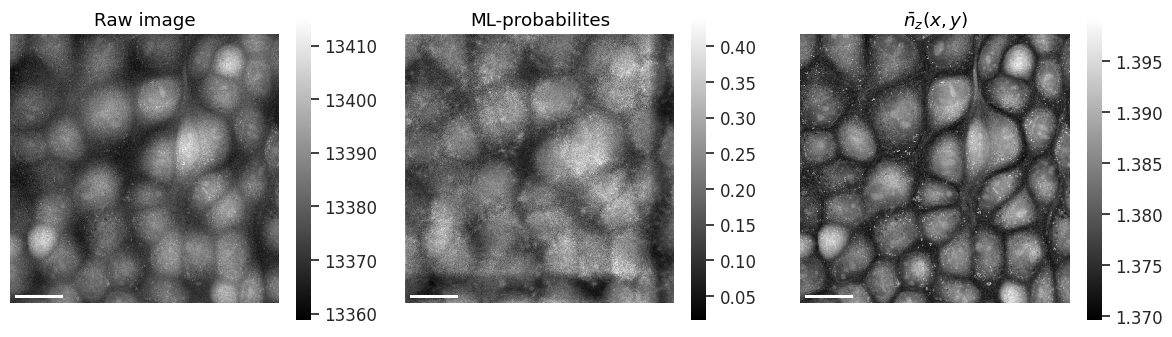

In [7]:
fig, ax = plt.subplots(1,3, figsize=(12,3.5))
sns.set_theme(style='ticks', palette='deep', font_scale=1.1)

sns.heatmap(im_raw,  ax=ax[0], square=True, cmap="gray", xticklabels=False, yticklabels=False)
sns.heatmap(im_prob, ax=ax[1], square=True, cmap="gray", xticklabels=False, yticklabels=False)
sns.heatmap(im_n_z,  ax=ax[2], square=True, cmap="gray", xticklabels=False, yticklabels=False)

for i,c in zip(range(3), ["w", "w", "w"]):
    sb = ScaleBar(vox_to_um[2], 'um', box_alpha=0, color=c, scale_loc="none")
    sb.location = 'lower left'
    ax[i].add_artist(sb)

ax[0].set(title="Raw image")
ax[1].set(title="ML-probabilites")
ax[2].set(title=r"$\bar{n}_z(x,y)$")

fig.tight_layout()

In [8]:
fig.savefig(f"../../figs/image_preprocessing.png")

In [9]:
z0 = 33
x_raw  = np.mean(raw, axis=1)
y_raw  = np.mean(raw, axis=2)
z_raw  = np.mean(raw, axis=(1,2))
dz_raw = np.diff(z_raw)

z_arr  = np.arange(0, 78)
dz_arr = np.arange(0, 77) + 0.5
z0_arr = z0 * np.ones_like(z_arr)

z0_im = z0 * np.ones(len(raw[0]))
xy_arr = np.arange(0, len(raw[0]))

vmin = np.min([x_raw, y_raw])
vmax = np.max([x_raw, y_raw])

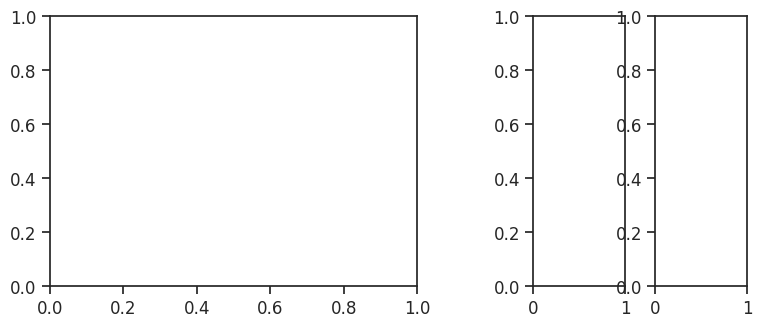

In [196]:
#color = "crimson"
width_ratios = [2, 0.3, 0.5, 0.5]

# Define the GridSpec layout
gs = gridspec.GridSpec(1, 4, width_ratios=width_ratios)
gs.update(wspace=0.2, hspace=0.2)  # Adjust space between plots

fig = plt.figure(figsize=(9,3.5))
sns.set_theme(style='ticks', palette='deep', font_scale=1.1)

imx = fig.add_subplot(gs[0])
p0 = fig.add_subplot(gs[2])
p1 = fig.add_subplot(gs[3], sharey = p0)

In [197]:
p0.plot(z_raw, z_arr,   color="b")
p1.plot(dz_raw, dz_arr, color="b")

sns.heatmap(x_raw, ax=imx, square=False, vmin=vmin, vmax=vmax, cmap="gray", xticklabels=False, yticklabels=False)
imx.invert_yaxis()

p0.hlines(z0, np.min(z_raw), np.max(z_raw), ls="dashed", color="turquoise")
p1.hlines(z0, np.min(dz_raw), np.max(dz_raw), ls="dashed", color="turquoise")
imx.plot(xy_arr, z0_im, '--',     color="turquoise", alpha=0.5)

p0.set(ylim=(0,78))
p0.set_yticks([0, 20, 40, 60])
p0.axes.get_xaxis().set_visible(False)
p1.axes.get_xaxis().set_visible(False)
p1.axes.get_yaxis().set_visible(False)
sns.despine(ax=p0)
sns.despine(ax=p1)

/tmp/ipykernel_18669/475946925.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


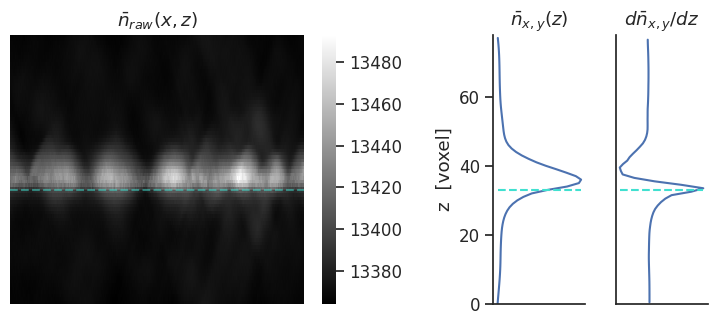

In [200]:
p0.set(title=r"$\bar{n}_{x,y}(z)$", ylabel="z  [voxel]")
p1.set(title=r"$d\bar{n}_{x,y}/dz$")
imx.set(title=r"$\bar{n}_{raw}(x,z)$")

fig.tight_layout()
fig

In [181]:
fig.savefig(f"../../figs/image_preprocessing_cell_bottom.png")